In [1]:
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 15}
matplotlib.rc('font', **font)

#time
from datetime import datetime, timedelta
import time

#matlab import
import scipy.io
from scipy.io import savemat

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

from nanodrivers.visa_drivers.vna import VNA
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.signal_analyser import Anri

C:\Users\Demag\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [94]:
anapico = ANAPICO()
anapico.idn()

Connection exist: AnaPico AG,APMS20G,3C6-0B4F40003-0985,0.4.209



In [95]:
vna = VNA(device_num="TCPIP0::169.254.36.111::hislip0::INSTR")
vna.idn()

Connection exist: Rohde-Schwarz,ZNB20-2Port,1311601062102129,3.45



In [96]:
anri = Anri()
anri.idn()

Connection exist: ANRITSU,MS2830A,6200847105,4.09.01



In [130]:
# Global variables
data_sweeps = []
anri_parameters = [] # (fLowBound, fUppBound, power, freq_dist, cent_freq)
vna_data = []
vna_parameters = [] # (start_freq, end_freq, power)

In [131]:
# Sets up the measuring window (span) and precision (band)
def setUp(band_Hz=float, span=float):
    anapico.set_on(3)
    anapico.set_on(4)
    anri.set_band_Hz(band_Hz)
    anri.set_span(span)
    print('Ch3: ' + str(anapico.get_status(3)))
    print('Ch4: ' + str(anapico.get_status(4)))
    print('Span: ' + str(anri.get_span()))

In [132]:
def sweep(cent_freq=float, sweep_span=float, noSteps = int, freqDist = float, power = int):
    span = anri.get_span()
    global data_sweeps
    global anri_parameters
    
    start_freq = cent_freq - sweep_span / 2
    end_freq = cent_freq + sweep_span / 2
    df = (end_freq - start_freq) / noSteps
    f = start_freq
    
    for i in range(noSteps + 1):
        anri.set_cent_freq(f)
        anapico.set_freq(3, f - freqDist / 2)
        anapico.set_freq(4, f + freqDist / 2)
        anapico.set_power(3, power)
        anapico.set_power(4, power)
        data = anri.get_data() 
        data_sweeps.append(data) # appends the measurement data to data_sweeps
        anri_parameters.append((f - span / 2, f + span / 2, power, freqDist, f)) # appends the frequency window of the measurement to 
        f = f + df
        print(i) # prints a stamp at each cycle. In the end should be the numper of steps performed.
                           
    #updates data_sweeps and freq_window

In [133]:
setUp(100, 1e6)

Ch3: 1.0
Ch4: 1.0
Span: 1000000.0


In [75]:
for i in range(4):
    sweep(cent_freq=3.79905e9, sweep_span=2e6, noSteps=20, freqDist=50e3, power = -10 - 5*i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [ ]:
anri.set_cent_freq(3.79905e9)
anapico.set_freq(3, 3.799055e9)
anapico.set_freq(4, 3.799045e9)
anapico.set_power(3, -20)
anapico.set_power(4, -20)

In [ ]:
test = vna.get_data()

In [24]:
print(len(data_sweeps[0]))
print(len(vna_data[0]))

10001
1001


In [76]:
def vna_meas_anaOn(cent_freq=float, span=float, start_pow=int, end_pow=int, pow_increments=int):
    vna.write('INIT1:CONT ON')
    vna.set_span(span)
    vna.set_cent_freq(cent_freq)
    anapico.set_on(3)
    anapico.set_on(4)
    
    start_freq = cent_freq - span / 2
    end_freq = cent_freq + span / 2
    power = start_pow
    
    while power >= end_pow:
        anapico.set_power(3, power)
        anapico.set_power(4, power)
        vna.set_power(power)
        vna_data.append(vna.get_data()[0])
        vna_parameters.append((start_freq, end_freq, power))
        print(power)
        power = power + pow_increments

In [129]:
def vna_meas_anaOff(cent_freq=float, span=float, start_pow=int, end_pow=int, pow_increments=int):
    vna.write('INIT1:CONT ON')
    vna.set_span(span)
    vna.set_cent_freq(cent_freq)
    anapico.set_off(3)
    anapico.set_off(4)
    
    start_freq = cent_freq - span / 2
    end_freq = cent_freq + span / 2
    power = start_pow
    
    while power >= end_pow:
        vna.set_power(power + 10*np.log10(2))
        vna_data.append(vna.get_data()[0])
        vna_parameters.append((start_freq, end_freq, power))
        print(power)
        power = power + pow_increments

In [134]:
vna_meas_anaOff(3.79905e9, 3e6, -10, -35, -5)
#print(len(vna_data))

-10
-15
-20
-25
-30
-35


In [103]:
def convert_dBm_dB(ref_pow=float, input_pow=float): # ref_pow[W], input_pow[dBm]
    input_W = 1e-3*pow(10, input_pow/10) #dBm to W
    input_dB = 10*log(input_W/ref_pow) #W to dB
    return input_dB

In [108]:
ref_pow = 1e-3*pow(10, -10/10)
convert_dBm_dB(ref_pow, -35)

-57.564627324851145

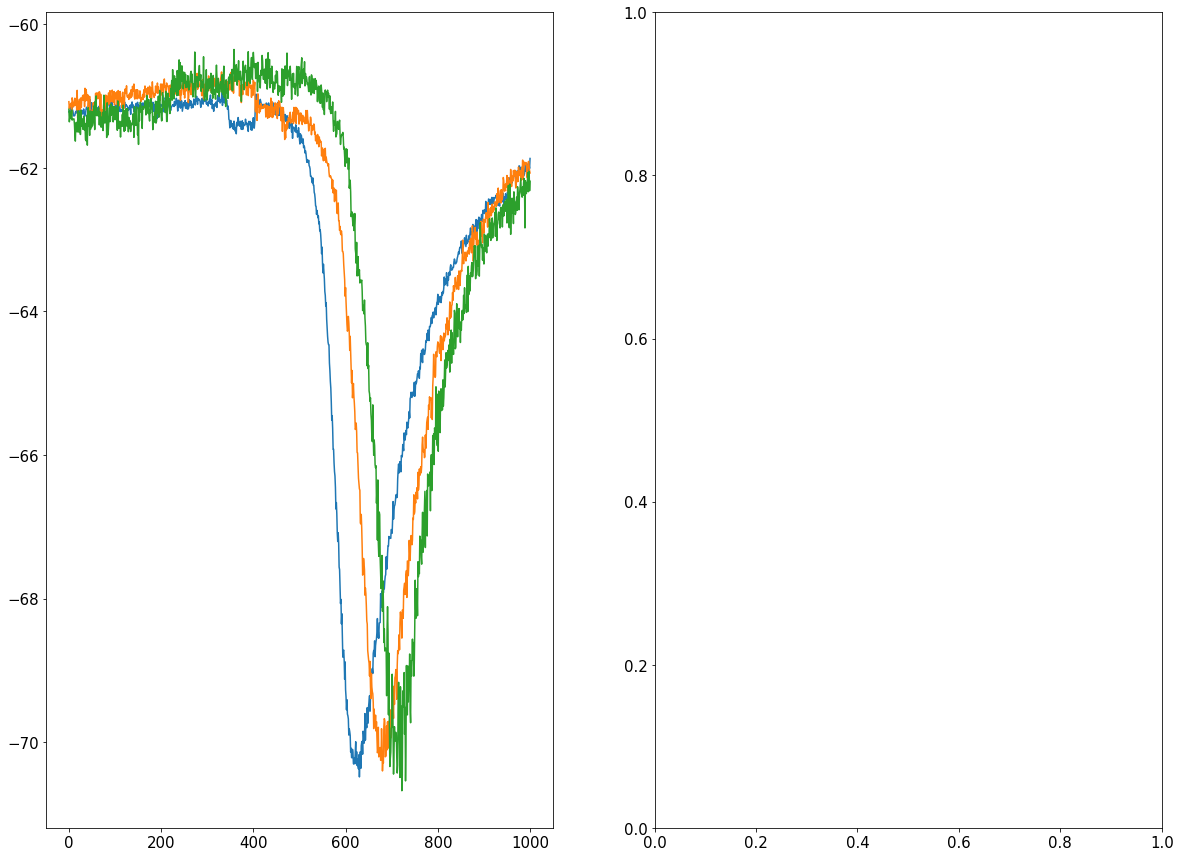

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].plot(vna_data[0])
ax[0].plot(vna_data[1])
ax[0].plot(vna_data[2])

In [113]:
state=dict()
state['temp'] = 7.4

state['dump_vna'] = vna.dump()
state['dump_anapico'] = anapico.dump()
state['data_sweeps'] = data_sweeps
state['anri_parameters'] = anri_parameters
state['vna_data'] = vna_data
state['vna_parameters'] = vna_parameters

In [114]:
state

{'temp': 7.4,
 'dump_vna': {'device': 'TCPIPInstrument at TCPIP0::169.254.36.111::hislip0::INSTR',
  'type': 'LIN',
  'ref_source': 'INT',
  'form': 0,
  'cent_freq': 3799050000.0,
  'span': 3000000.0,
  'star_freq': 3797550000.0,
  'stop_freq': 3800550000.0,
  'cw_freq': nan,
  'freq': array([3.797550e+09, 3.797553e+09, 3.797556e+09, ..., 3.800544e+09,
         3.800547e+09, 3.800550e+09]),
  'nop': 1001,
  'elength': 0.0,
  'status_output': 0,
  'band': 100.0,
  'power': -35,
  'avg_status': 0,
  'avgs': 1},
 'dump_anapico': {'device': 'TCPIPInstrument at TCPIP0::169.254.12.34::inst0::INSTR',
  'channel_status': array([0., 0., 0., 0.]),
  'channel_freqs': array([1.00000000e+09, 1.00000000e+09, 3.77872492e+09, 3.77872502e+09]),
  'channel_pows': array([  0.,   0., -40., -10.])},
 'data_sweeps': [],
 'anri_parameters': [],
 'vna_data': [array([-61.38482648, -61.49907685, -61.49628598, ..., -62.33515377,
         -62.23739127, -62.19345918]),
  array([-61.30256239, -61.38368759, -61.256

In [135]:
now = datetime.now()  
folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\IMS_summer_pro'
file = r'vna_data_2_'+ now.strftime(r'%Y%m%d%H%M%S') + '.mat'
file_name = folder +'\\' + file

In [136]:
savemat(file_name, state)

In [137]:
anapico.set_off(3) # turn off anapico after measurement
anapico.set_off(4)

In [138]:
print(anapico.get_status(3))
print(anapico.get_status(4))

0.0
0.0
